# ETL Data - COVID-19 datasets

To do any interesting analysis, we first need to collect some data and make it available for our use. Broadly speaking, this first step can be thought of as an [ETL operation](https://en.wikipedia.org/wiki/Extract,_transform,_load). In 2021, the most important global issue is the continuing COVID-19 pandemic, and researchers around the world have been working tirelessly to make available time series data related to cases, testing, and mortality, among other topics.

In this notebook, we will use three different strategies to ETL three COVID-19 datasets, and then we will replicate three useful visualizations. In each case, the data has admirably been made available to the world to use, free of charge. These things will take enough time to do that we won't end up using Statsmodels at all in this notebook.

## Datasets

### New York Times

The first dataset that we will use comes from the New York Times (see their [reporting](https://www.nytimes.com/news-event/coronavirus) and [maps](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html) that make use of the data), which has collected / collated a large amount of information about COVID-19 cases in the United States, and they have made this data freely available in a [Github repostory](https://github.com/nytimes/covid-19-data).

**ETL strategy**: since the data is relatively small is being made available as CSV files, we will simply (a) download the CSV files directly from Gitlab, (b) modify / transform the dataset to fit our purposes, and (c) store the data locally as a [parquet file](https://databricks.com/glossary/what-is-parquet).

**Visualization**: in this notebook, we'll use the NYTimes dataset to re-create their graph showing the evolution of new cases in the US over time. This graphic can usually be found on their website at the top of [this page](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html).

### The COVID Tracking Project

The second dataset that we will use is produced by [The COVID Tracking Project](https://covidtracking.com/), which is described on their [About Us page](https://covidtracking.com/about) as "a volunteer organization launched from The Atlantic and dedicated to collecting and publishing the data required to understand the COVID-19 outbreak in the United States".

**ETL strategy**: the COVID Tracking Project makes their data available through an [API](https://covidtracking.com/data/api). This API is ultimately backed by a set of CSV files on Github, similar to the NYTimes dataset, but it also makes available historical vintaged data (i.e. data as it was available on a given day), which will allow us to use a slightly more nuanced ETL strategy. Instead of simply downloading the latest CSV file, which involves re-downloading a lot of data already stored locally, we will construct a few simple functions that allow us to only download the incremental new data. As with the NYTimes data, we will store the results as a parquet file.

**Visualization**: in this notebook, we'll use the COVID Tracking Project dataset to re-create the four graphs that make up their "National Overview" (click on the "National Overview" tab of [this page](https://covidtracking.com/)).


### Google COVID-19 public datasets / BigQuery

Finally, Google is curating and making available a set of "[COVID-19 public datasets](https://cloud.google.com/blog/products/data-analytics/publicly-available-covid-19-data-for-analytics)" that include global data about the COVID-19 pandemic. The data, their ETL code, and information about sources is available in a [Github repository](https://github.com/GoogleCloudPlatform/covid-19-open-data/). However, Google has gone further and made the COVID-19 data available as part of their [BigQuery Public Datasets Program](https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/covid19-public-data-program). This means that we can use BigQuery to interact with the dataset using SQL-like queries, and these queries will be [free until September 15, 2021](https://cloud.google.com/blog/products/data-analytics/publicly-available-covid-19-data-for-analytics).

**ETL strategy**: in this notebook, we'll just use Google's [BigQuery Python libriary](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python) to query the data directly. The managed BigQuery service is convenient enough that for the visualization we're creating here, we don't need to do any custom ETL work (other than writing the query) or store the output data locally, although we might do so in later notebooks.

**Visualization**: in this notebook, we'll combine the Google dataset with the [`plotly`](https://plotly.com/) Python package to create a map of new deaths from COVID-19 in the past week, at the level of US counties.

In [2]:
# Basic imports that we will use throughout the notebook
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## New York Times

For many projects, the most convenient method of retrieiving data is simply to download the entire dataset as a flat file. We'll do that with the latest data from the New York Times, and our ETL process will be as follows:

1. **Extract step**: Download the data and load it into a Pandas DataFrame. In fact, Pandas `read_csv` (and its other `read_*` functions) handles the downloading part for us, so we never end up actually storing the raw CSV file. We can also use it to handle the date transformations using `parse_dates` and `asfreq` (the latter is useful because while `parse_dates` does create a `DatetimeIndex`, it does not assign it a frequency, which is very helpful)
2. **Transform steps**: Our analysis in this notebook is pretty simple (just a visualization), so we don't need to do much to the dataset. Still, we need to compute three new columns.

   1. First, "new cases" are equal to the total cases today minus the total cases yesterday, computed via the `diff` method.
   2. Second, to smooth through seasonal variation in reporting over the course of the datas of the week, we compute a 7-day rolling average.
   3. Finally, there are some days that are anomalous in terms of new cases reported, and we want to flag these as such. For now, we're just using the days flagged as anomalous by the New York Times (which include Thanksgiving and Christmas), but in a later notebook we'll see if we can use outlier detection methods to identify them automatically.
3. **Load step**: after creating the additional columns, we'll just save the resulting DataFrame to a file using the parquet format. With a dataset this small, the format is not essential, but for time series data, parquet is a generally nice format to use.

In [3]:
# Extract: download the data (here, load the CSV directly from the URL)
nytimes = pd.read_csv(
    'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv',
    index_col=['date'], parse_dates=['date']).asfreq(freq='D')

# Transform: add new columns with useful transformations
nytimes['new_cases'] = nytimes['cases'].diff()
nytimes['new_cases_ma7'] = nytimes['new_cases'].rolling(7).mean()

anomalous_dates = ['2020-09-21', '2020-11-26', '2020-12-11', '2020-12-25']
nytimes['anomaly'] = False
nytimes.loc[anomalous_dates, 'anomaly'] = True

# Load: save dataset as "us.parquet"
nytimes_path = pathlib.Path('./data/nytimes/')
nytimes_path.mkdir(parents=True, exist_ok=True)
nytimes.to_parquet(nytimes_path / 'us.parquet')

### Visualization: new cases

We will use the data we just retrieved to recreate the plot used at the top of this page: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.

Although within this notebook we still have the downloaded data available, to make the visualization code more modular, we'll use Pandas' `read_parquet` function to read in the columns we want from the parquet file we stored.

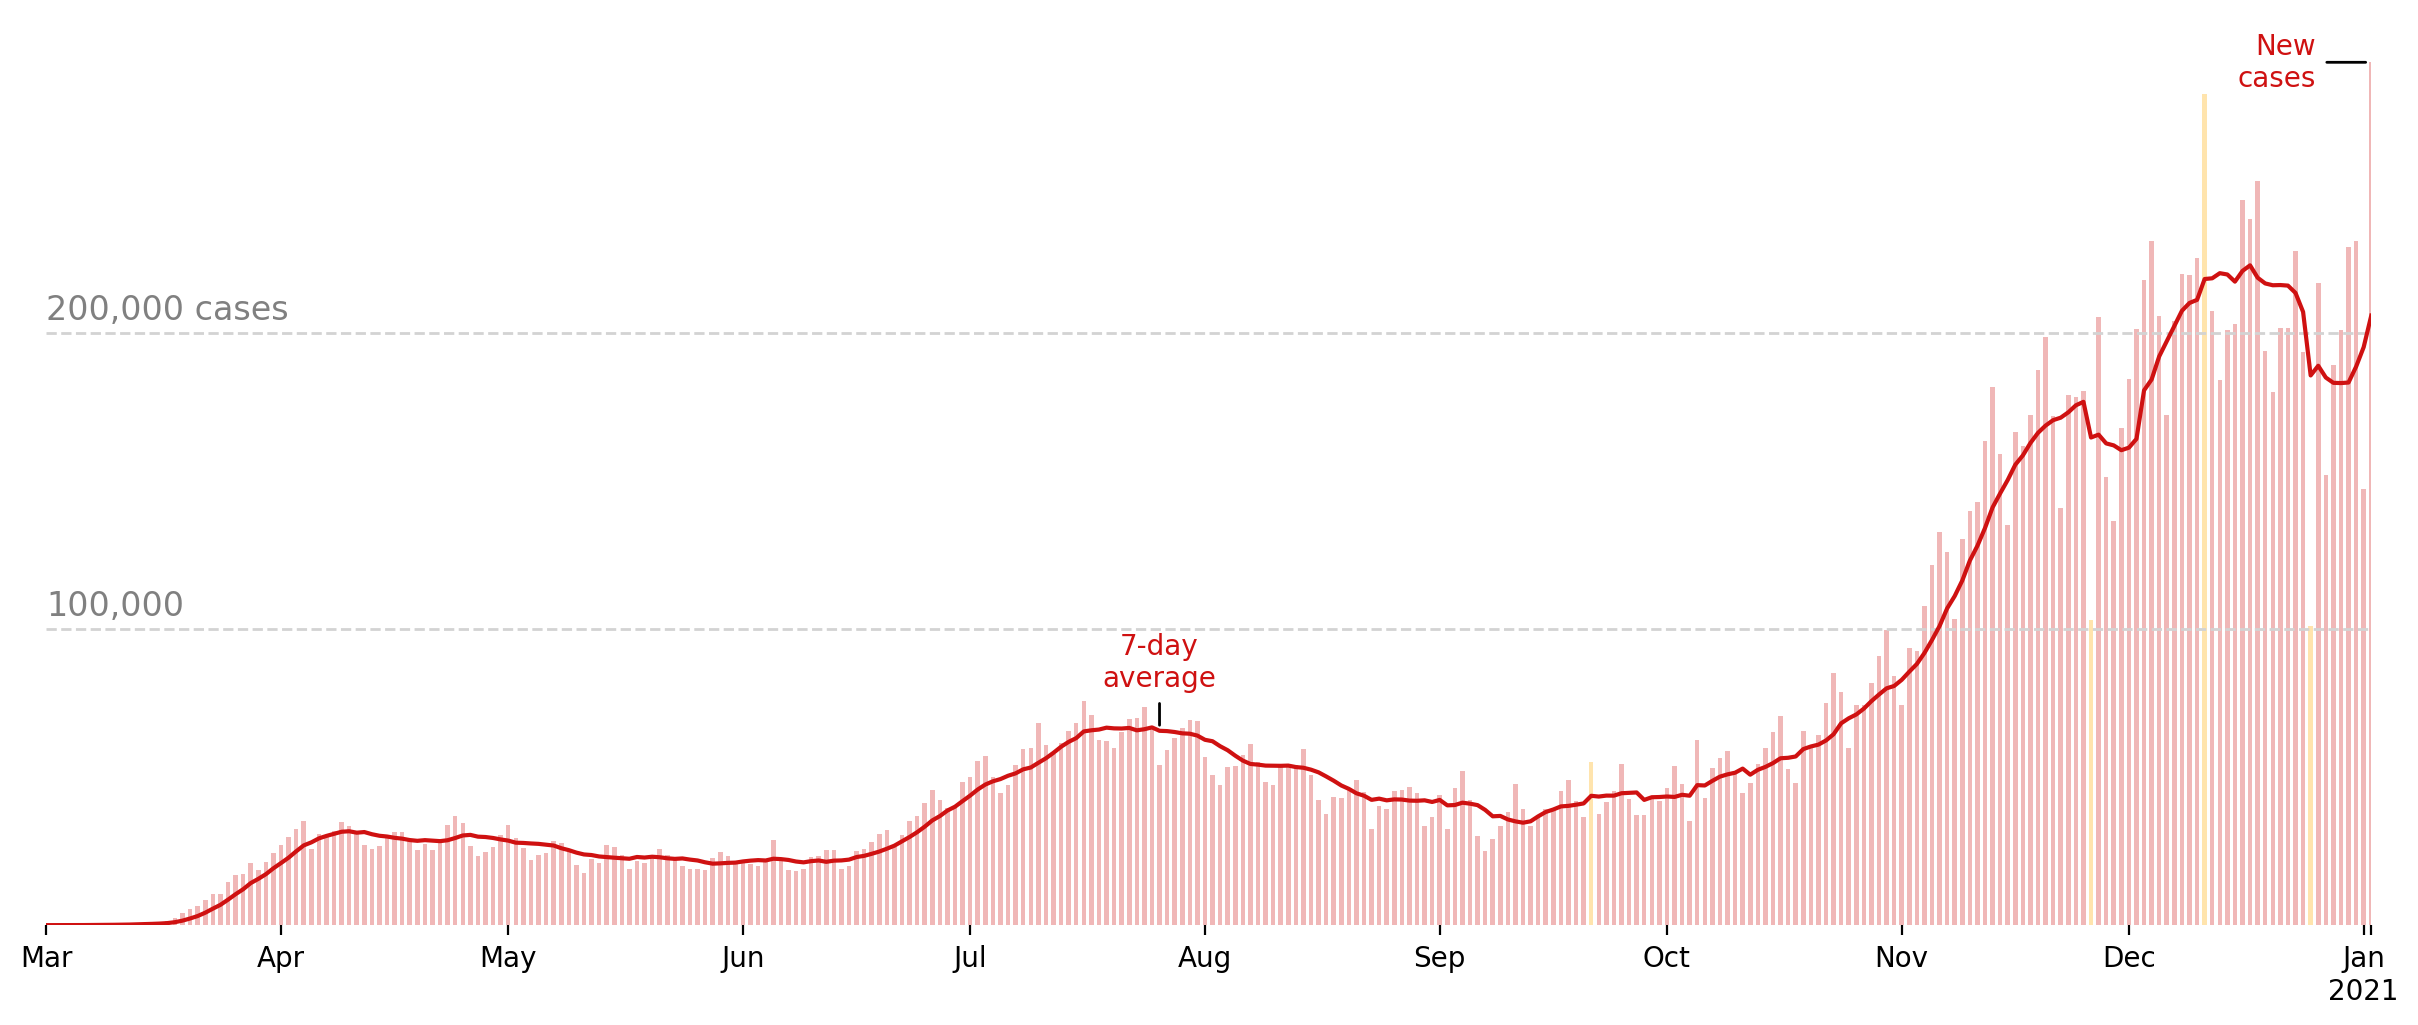

In [4]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=200)

# Colors
normal_color = '#cf1111'
anomaly_color = '#ffe4ad'

# Subset our data for plotting, and separate into normal and anomalous
to_plot = pd.read_parquet(
    nytimes_path / 'us.parquet',
    columns=['new_cases', 'new_cases_ma7', 'anomaly']).loc['2020-03':]
normal = to_plot.query('not anomaly')
anomalous = to_plot.query('anomaly')

# Add new cases rolling average and annotation
to_plot['new_cases_ma7'].plot(color=normal_color, ax=ax)

label_date = '2020-07-26'
ax.annotate('7-day\naverage',
            xy=(label_date, to_plot['new_cases_ma7'].loc[label_date]),
            xytext=(0, 16), textcoords='offset points',
            horizontalalignment='center',
            arrowprops=dict(arrowstyle="-"),
            color=normal_color)

# Add new cases bar plot and annotation
ax.bar(normal.index, normal['new_cases'], width=0.6, color=normal_color,
       alpha=0.3)
ax.bar(anomalous.index, anomalous['new_cases'], width=0.6, color=anomaly_color)

label_date = normal.index[normal.new_cases.argmax()]
ax.annotate('New\ncases',
            xy=(label_date, to_plot['new_cases'].loc[label_date]),
            xytext=(-20, 0), textcoords='offset points',
            horizontalalignment='right',
            verticalalignment='center',
            arrowprops=dict(arrowstyle="-"),
            color=normal_color)

# Add and annotate horizontal grid lines
ax.hlines(100_000, to_plot.index[0], to_plot.index[-1], color='lightgray',
          linestyle='--', linewidth=1)
ax.hlines(200_000, to_plot.index[0], to_plot.index[-1], color='lightgray',
          linestyle='--', linewidth=1)

ax.annotate('200,000 cases',
            xy=('2020-03-01', 200_000),
            xytext=(0, 5), textcoords='offset points',
            fontsize='large', color='gray')
ax.annotate('100,000',
            xy=('2020-03-01', 100_000),
            xytext=(0, 5), textcoords='offset points',
            fontsize='large', color='gray')

# Styling
[ax.spines[spine].set_visible(False)
 for spine in ['top', 'right', 'bottom', 'left']]
ax.yaxis.set_ticks([])
ax.minorticks_off()
ax.set_xlabel('');

## The COVID Tracking Project

In this case, we'll use the COVID Tracking project's [API](https://covidtracking.com/data/api), although since it exposes CSV files, we can continue to download the data with Pandas' `read_csv` function. The basic ETL strategy is:

1. On first run, download the historic CSV containing the most recent data.
2. On subsequent runs, download each daily update since the last data was stored, append the new rows to the stored dataset.
3. Remove duplicates, keeping only more recently updated rows.
4. Store data (again, in parquet format)

There are two changes that we make to the timestamps returned by the COVID tracking project:

1. While Python recognizes only hours 0 - 23, the COVID tracking project stores some timestamps as 24:00:00. While it might be possible that they are using hours 1 - 24 (so that 24:00:00 would correspond to 11pm), I think it's more likely that it indicates data that corresponds to the "entire day", and 24:00:00 is a representation of the last possible moment of a given day. Regardless of the reason, Python will not parse a timestamp with 24 in the hour position, so we need an intermediate step to make some conversion that Python will accept. Based on my interpretation above, I decided to replace these with the last second of the day, 23:59:59.
2. The second issue is that the COVID tracking project reports timestamps in UTC (this is the "Z" at the end of each timestamp), but for our purposes we're not concerned about the time zone, and we will convert these back to naive timestamps.

In [5]:
def parse_datetime(column):
    """
    Parse column of COVID Tracking Project timestamps
    
    Parameters
    ----------
    column : pd.Series
        Column of string timestamp values.
        
    Returns
    ----------
    datetime : pd.DatetimeIndex
        Date/time index of timestamp values.
    
    Notes
    -----
    1. Replace 24:00:00 -> 23:59:59
    2. Convert from UTC to naive
    """
    # Split into date and time
    split = column.str.split('T', expand=True)
    split['date'] = pd.PeriodIndex(split[0], freq='D')
    split.rename({1: 'time'}, axis=1, inplace=True)

    # Identify rows where the time=24:00:00 indicates midnight next day
    mask = (split['time'] == '24:00:00Z')
    split.loc[mask, 'time'] = '23:59:59Z'

    # Timezone-aware datetime
    datetime = pd.DatetimeIndex(split['date'].astype(str) + 'T' + split['time'])
    # Convert to naive datetime
    datetime = datetime.tz_localize(None)
    return datetime


def append_data(data, url):
    """
    Download updated COVID Tracking data and append to existing dataset
    
    Parameters
    ----------
    data : pd.DataFrame
        Stored dataset. We will append new rows to this dataset.
    url : str
        API URL associated with updated data in CSV format.
        
    Returns
    ----------
    data : pd.DataFrame
        Updated dataset, with new rows included and older duplicate
        rows removed.
    """
    # Download the data from `url`
    update = pd.read_csv(
        url, index_col=['date'], parse_dates=['date']).sort_index().asfreq('D')

    # Parse lastModified
    update['lastModified'] = parse_datetime(update['lastModified'])

    # Append new rows
    data = pd.concat([data, update])

    # Sort and remove older duplicates
    data = data.sort_values(['date', 'lastModified'])
    data = data[~data.index.duplicated(keep='last')]
    return data


def etl_data(path):
    """
    ETL COVID Tracking Project dataset
    
    Parameters
    ----------
    path : str or pathlib.Path
        Path to local storage for COVID Tracking Project data.
        
    Returns
    -------
    data : pd.DataFrame
        Updated COVID Tracking Project dataset.
    """
    path = pathlib.Path(path)
    base_url = 'https://api.covidtracking.com/v1/'

    try:
        # Try to load the existing dataset
        data = pd.read_parquet(path)
    except (FileNotFoundError, OSError):
        # But if it doesn't exist, download the historical data
        data = pd.read_csv(
            base_url + 'us/daily.csv', index_col=['date'],
            parse_dates=['date']).sort_index().asfreq('D')
        data['lastModified'] = parse_datetime(data['lastModified'])
        data.to_parquet(path)
        
    # Figure out the last update datetime and curent datetime
    last_updated = data.lastModified.max()
    now = pd.Timestamp('today')
    last_updated_day = last_updated.to_period(freq='D')
    today = now.to_period(freq='D')
    
    # Check for missing days (excluding today, which we will handle
    # separately, below)
    missing = pd.period_range(start=last_updated_day + 1, end=today - 1,
                              freq='D')
    for day in missing:
        # Retrieve the new data
        url = base_url + f'us/{day.strftime("%Y%m%d")}.csv'
        data = append_data(data, url)
        
    # Retrieve the most recent update (for today)
    url = base_url + 'us/current.csv'
    data = append_data(data, url)
    
    # Save dataset
    data.to_parquet(path)

    return data

### Visualization: "National COVID-19 topline metrics"

Here we will replicate the "National COVID-19 topline metrics" from the "National overview" tab of https://covidtracking.com/.

First, it is simple to retrieve the most updated data given the functions `etl_data`, `append_data`, and `parse_datetime` defined above.

Then it is relatively straightforward to construct each of the four graphs, since they are similar in construction to the New York Times "new cases" graph above.

In [6]:
# Retrieve and/or update our data from the COVID Tracking Project.
tracking_path = pathlib.Path('./data/covidtracking')
tracking_path.mkdir(parents=True, exist_ok=True)
data = etl_data(tracking_path / 'us.parquet')

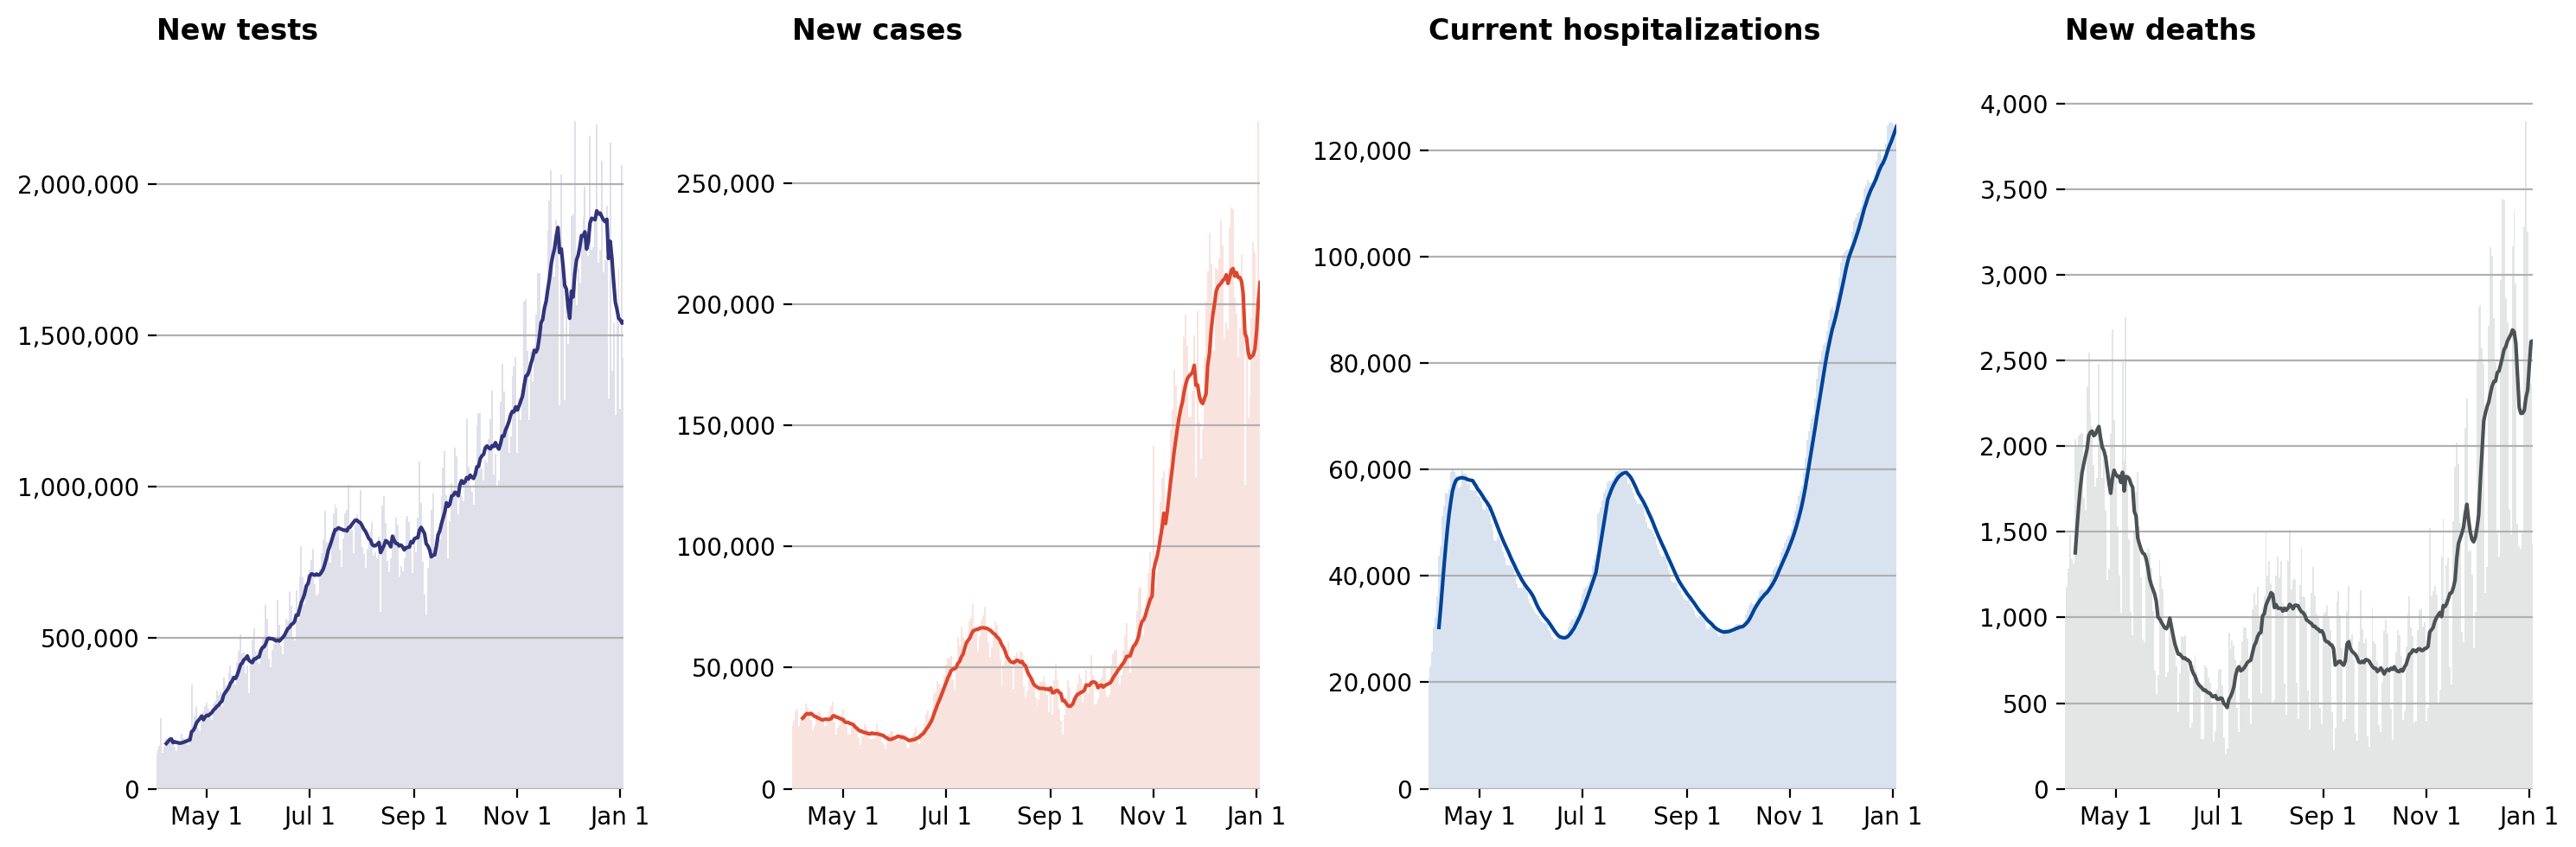

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), dpi=200)

graphs = pd.DataFrame({
    'title':  ['New tests', 'New cases',
               'Current hospitalizations', 'New deaths'],
    'column': ['totalTestResultsIncrease', 'positiveIncrease',
               'hospitalizedCurrently', 'deathIncrease'],
    'color': ['#31347a', '#dc472e', '#004399', '#4c5153'],
})

start = '2020-04-01'

for ix, (title, column, color) in graphs.iterrows():
    ax = axes[ix]
    series = data.loc[start:, column]

    series.rolling(7).mean().plot(color=color, ax=ax)
    ax.bar(series.index, series, width=1, color=color, alpha=0.15)
    [ax.spines[spine].set_visible(False)
     for spine in ['top', 'right', 'bottom', 'left']]
    
    # General
    ax.set_title(title + '\n', fontweight='bold', loc='left')

    # y-axis
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.grid()

    # x-axis
    months = pd.date_range('2020-05-01', series.index[-1], freq='MS')[::2]
    dates = months.tolist()
    if ((series.index[-1].year > months[-1].year) or
            (series.index[-1].month > months[-1].month)):
         dates.append(series.index[-1])
    ax.xaxis.set_ticks(dates)
    ax.xaxis.set_ticklabels([date.strftime('%b %-d') for date in dates])
    ax.minorticks_off()
    ax.set_xlabel('')

fig.tight_layout()

## Google COVID-19 public datasets / BigQuery

Finally, we can use the `bigquery` Python library to directly query Google's COVID-19 public datasets. This is conveninent because (1) we can use an SQL-type query to work with the datasets so that we only download the data we actually need, and (2) we can download the data directly into a Pandas DataFrame.

To get starting using this dataset via BigQuery, there are a few steps that must be completed, such as:

- [Create an account and project with Google Cloud Platform](https://cloud.google.com/bigquery/public-data#before_you_begin)
- [Download the Google cloud library for Python (usually using either `pip` or Anaconda)](https://cloud.google.com/bigquery/docs/reference/libraries#installing_the_client_library)
- [Set up authentication for accessing your project](https://cloud.google.com/bigquery/docs/reference/libraries#setting_up_authentication)

In this case, we will work with county-level data, which corresponds to `aggregation_level = 2` for US data. The `subregion2_code` field records the [FIPS code](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code) for each county, which is convenient for working with mapping tools.



In [8]:
from google.cloud import bigquery

# Handle authentication in Colab
try:
    from google.colab import auth
    auth.authenticate_user()
    print('Authenticated')
except ImportError:
    pass

# Construct a BigQuery client object.
client = bigquery.Client(project='sm-notebooks-2021')

query = """
SELECT
  subregion2_code as fips,
  subregion2_name as county,
  date,
  new_deceased
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
  country_code = 'US'
  AND aggregation_level = 2
  AND new_deceased IS NOT NULL
  AND date >= DATE_SUB(CURRENT_DATE(), INTERVAL 8 DAY);
"""
res = (client.query(query)
             .result()
             .to_dataframe())
res['date'] = pd.DatetimeIndex(res['date'])

# In the query above, we downloaded the last week of data, and
# here we're summing it to get the total value over the week.
df = res.groupby(['fips', 'county'], as_index=False).sum()

### Visualization: 

Since the Google dataset included the FIPS code for each county, it is pretty straightforward to follow the example at https://plotly.com/python/choropleth-maps/ to create a Choropleth of new deaths over the past week.

In [9]:
import plotly.express as px
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

try:
    fig = px.choropleth(df, geojson=counties, locations='fips',
                        color='new_deceased', color_continuous_scale="sunsetdark",
                        range_color=(0, 20),
                        scope="usa",
                        hover_name='county',
                        labels={'new_deceased': 'New Deaths'})
    fig.update_traces(marker_line_width=0.5)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
except TypeError:
    print('Choropleth in this notebook requires plotly >= 4.5')